In [ ]:
from fastai.vision.all import *
from fastai.callback.wandb import WandbCallback
import wandb
import pandas as pd
import matplotlib.pyplot as plt

## Background

In [my previous blog post](https://vishalbakshi.github.io/blog/posts/2025-06-01-imagenette/) and [video](https://youtu.be/5xCUEaowcTE) I worked through my initial imagenette experiments.

> Imagenette is a subset of 10 easily classified classes from Imagenet (tench, English springer, cassette player, chain saw, church, French horn, garbage truck, gas pump, golf ball, parachute).

With a batch size of 64 and three different LRs (1e-4, 1e-3, 1e-2) I achieved the following results using three models (xresnet34, xse_resnext50, xresnet18):

|Model/Learning Rate|Accuracy|
|:-:|:-:|
|xresnet34/1e-2|0.7929
|xse_resnext50/1e-2|0.7926
|xresnet18/1e-2|0.7870
|xresnet34/1e-3|0.7776
|xresnet18/1e-3|0.7743
|xse_resnext50/1e-3|0.7526
|xresnet18/1e-1|0.7373
|xse_resnext50/1e-4|0.6532
|xresnet34/1e-4|0.6446
|xresnet18/1e-4|0.6171

There was a hierarchy of LRs: 1e-2 performed best, followed by 1e-3 and 1e-4.

In this notebook I'm going to expand my training runs to more batch sizes: [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]. In each case, I'll use `lr_find` to determine three stable learning rates.

## Results

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("/content/2025-06-04-imagenette-runs.csv")
df["model"] = df["run"].apply(lambda x: x.split("-")[1])
df["bs"] = df["run"].apply(lambda x: x.split("-")[3]).astype(int)

def _lr(x):
    _map = {"05": "1e-5", "06": "1e-6", "07": "1e-7", "0.0001": "1e-4", "0.001": "1e-3", "0.01": "1e-2", "0.1": "1e-1"}
    return _map[x.split("-")[-1]]

df["lr"] = df["run"].apply(lambda x: _lr(x))
df["lr"] = pd.Categorical(df["lr"], categories=["1e-7", "1e-6", "1e-5", "1e-4", "1e-3", "1e-2", "1e-1"])

In total there were 123 training runs.

In [10]:
df.shape

(123, 5)

The best training run goes to xresnet34 with a batch size of 16 and a learning rate of 1e-3.

In [11]:
df[df['acc'] == df['acc'].max()]

,run,acc,model,bs,lr
9,imagenette-xresnet34-bs-16-lr-0.001,0.800764,xresnet34,16,1e-3


The top 10 training runs were for a LR of 1e-3 or 1e-2.

In [12]:
df.sort_values("acc", ascending=False).head(10)

,run,acc,model,bs,lr
9,imagenette-xresnet34-bs-16-lr-0.001,0.800764,xresnet34,16,1e-3
66,imagenette-xresnet18-bs-32-lr-0.01,0.799745,xresnet18,32,1e-2
75,imagenette-xresnet18-bs-64-lr-0.01,0.797452,xresnet18,64,1e-2
7,imagenette-xresnet18-bs-16-lr-0.01,0.796433,xresnet18,16,1e-2
16,imagenette-xresnet18-bs-8-lr-0.001,0.795414,xresnet18,8,1e-3
25,imagenette-xresnet34-bs-8-lr-0.001,0.795414,xresnet34,8,1e-3
6,imagenette-xresnet34-bs-16-lr-0.01,0.795159,xresnet34,16,1e-2
84,imagenette-xresnet18-bs-128-lr-0.01,0.791338,xresnet18,128,1e-2
76,imagenette-xresnet34-bs-64-lr-0.01,0.790573,xresnet34,64,1e-2
67,imagenette-xresnet34-bs-32-lr-0.01,0.789554,xresnet34,32,1e-2


All three models achieved a max accuracy within 1.2% of each other.

In [14]:
df.groupby(["model"])["acc"].max().sort_values(ascending=False)

,acc
model,
xresnet34,0.800764
xresnet18,0.799745
xse_resnext50,0.788280


A batch size of 16 yielded the highest accuracy, with 8, 32, 64 and 128 within 1%. Accuracy drops significantly for a batch size of 1, 1024 and 2048 showing that too large or too small a batch size is detrimental to training.

In [16]:
df.groupby(["bs"])["acc"].max().sort_values(ascending=False)

,acc
bs,
16,0.800764
32,0.799745
64,0.797452
8,0.795414
128,0.791338
4,0.784968
256,0.764841
512,0.731975
2,0.719745


As we saw earlier, the highest accuracy was achieved with a learning rate of 1e-3, with 1e-2 right on its tail.

In [18]:
df.groupby(["lr"], observed=True)["acc"].max().sort_values(ascending=False)

,acc
lr,
1e-3,0.800764
1e-2,0.799745
1e-4,0.715414
1e-5,0.526624
1e-6,0.304713
1e-7,0.150828


Finally, I'll look at the maximum accuracy achieved for each model/learning rate/batch size combination.

For xresnet18, some interesting patterns:

- For each learning rate, the maximum accuracy increases up to a point, then decreases, illustrating how batch sizes too small or too large lead to worse performance
    - 1e-4: acc increases up to bs=8 then decreases
    - 1e-3: acc increases up to bs=8 then decreases
    - 1e-2: acc increases up to bs=32 then decreases

In [21]:
_df = df.query("model == 'xresnet18'")
pd.crosstab(df["lr"], _df["bs"], values=_df["acc"], aggfunc="max").sort_index(ascending=True)

bs,1,2,4,8,16,32,64,128,256,512,1024,2048
lr,,,,,,,,,,,,
1e-4,0.388535,0.608153,0.693503,0.704968,0.698089,0.665478,0.624713,0.512102,0.400000,0.310318,0.146497,0.000255
1e-3,0.452229,0.709809,0.778344,0.795414,0.789299,0.784968,0.769427,0.744713,0.719236,0.647389,0.544459,0.336306
1e-2,0.285605,0.649682,0.738089,0.778089,0.796433,0.799745,0.797452,0.791338,0.747006,0.731975,0.661147,0.485350


**xresnet18**

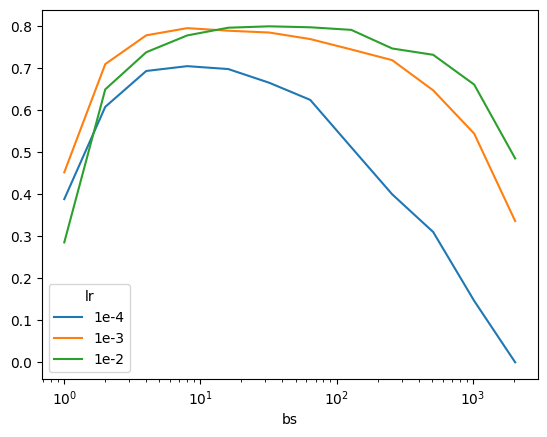

In [22]:
pd.crosstab(df["lr"], _df["bs"], values=_df["acc"], aggfunc="max").sort_index(ascending=True).T.plot(logx=True);

We see a similar pattern for xresnet34:

|lr|Inflection point (bs)|
|:-:|:-:|
|1e-7|--
|1e-6|--
|1e-5|4
|1e-4|16
|1e-3|16
|1e-2|16

In [23]:
_df = df.query("model == 'xresnet34'")
pd.crosstab(df["lr"], _df["bs"], values=_df["acc"], aggfunc="max").sort_index(ascending=True)

bs,1,2,4,8,16,32,64,128,256,512,1024,2048
lr,,,,,,,,,,,,
1e-7,NaN,0.109554,0.109045,0.087389,0.100892,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1e-6,NaN,0.243822,0.180127,0.201274,0.159236,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1e-5,NaN,0.385478,0.456051,0.446879,0.428535,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1e-4,0.388535,0.597962,0.704459,0.709809,0.715414,0.680764,0.641529,0.560510,0.489172,0.393376,0.269299,0.212229
1e-3,0.403567,0.719745,0.784968,0.795414,0.800764,0.787261,0.765860,0.751592,0.728408,0.667771,0.580127,0.430828
1e-2,0.246624,0.638217,0.721019,0.776306,0.795159,0.789554,0.790573,0.787006,0.764841,0.723312,0.662166,0.385732


**xresnet34**

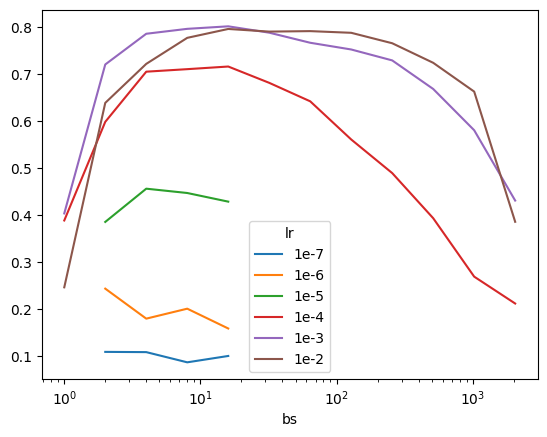

In [24]:
pd.crosstab(df["lr"], _df["bs"], values=_df["acc"], aggfunc="max").sort_index(ascending=True).T.plot(logx=True);

And a similar pattern for xse_resnext50 as well:

|lr|Inflection point (bs)|
|:-:|:-:|
|1e-7|8
|1e-6|--
|1e-5|--
|1e-4|8
|1e-3|16
|1e-2|32

In [25]:
_df = df.query("model == 'xse_resnext50'")
pd.crosstab(df["lr"], _df["bs"], values=_df["acc"], aggfunc="max").sort_index(ascending=True)

bs,2,4,8,16,32,64,128,256,512
lr,,,,,,,,,
1e-7,0.106497,0.127389,0.150828,0.126624,NaN,NaN,NaN,NaN,NaN
1e-6,0.117452,0.234395,0.291465,0.304713,NaN,NaN,NaN,NaN,NaN
1e-5,0.239745,0.420127,0.502675,0.526624,NaN,NaN,NaN,NaN,NaN
1e-4,0.203057,0.568917,0.661147,0.660382,0.652229,0.639236,0.623949,0.601019,0.575541
1e-3,0.186752,0.642803,0.766624,0.774267,0.768917,0.743694,0.720510,0.699363,0.671847
1e-2,0.140637,0.263185,0.564586,0.736306,0.788280,0.770701,0.776306,0.763567,0.725605


**xse_xresnet50**

Looking at the accuracy curves for xse_resnext50 we see that it's more robust to larger batch sizes (the accuracy tapers off slower than xresnet34 and xresnet18 as batch size increases past the inflection point).

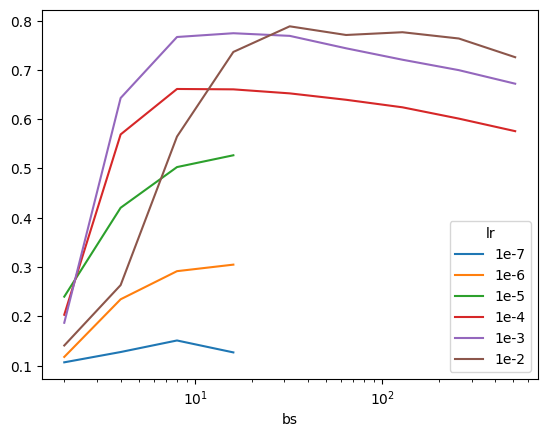

In [26]:
pd.crosstab(df["lr"], _df["bs"], values=_df["acc"], aggfunc="max").sort_index(ascending=True).T.plot(logx=True);

## Next Steps

I posted my initial musing (after I had analyzed results for batch sizes 32 to 2048) that lowering the batch size might continue to yield higher accuracy. Jeremy validated this approach:

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">That’s a great question! Stable low bs training isn’t easy, but it’s a good plan :)</p>&mdash; Jeremy Howard (@jeremyphoward) <a href="https://twitter.com/jeremyphoward/status/1930486029607416069?ref_src=twsrc%5Etfw">June 5, 2025</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

I recently started using Gemini Pro 2.5 (preview), and hadn't yet tried out its Deep Research tool. I thought this would be an excellent opportunity to do so. I prompted Gemini with the following:

> I recently have been training xresnet18, xresnet34 and xse_resnext50 on the Imagenette dataset by fast.ai (which is a 10k subset of ImageNet with 10 easily classified classes). I have trained on batch sizes from 1 to 2048. Generally speaking, the highest accuracy achieved increases from a batch size of 1 to a batch size of 8, 16 or 32 (depending on the model/learning rate) and then decreases as batch size increases to 2048. This makes me want to explore small batch size training for this project. Jeremy Howard tweeted that "Stable low bs training isn’t easy, but it’s a good plan". I want you to help me answer two questions in this chat:
>
>
> 1. Why is stable low batch size training difficult?
>
> 2. What techniques are there (either in literature/arxiv, blog posts or forums) to make low batch size training stable? I'm most interested in improving the accuracy of low batch size trainings.

I also prompted Allen AI's [Paper Finder](https://paperfinder.allen.ai/chat/606ffc67-5539-47a9-8c8a-ec5820666ccc?profile=paper-finder-only) with:

> strategies to make low batch size training more stable and improve accuracy for image recognition

I have shared the Gemini Deep Research and Ai2 Paper Finder findings in [another blog post](https://vishalbakshi.github.io/blog/posts/2025-06-18-small-batch-report/).

Imagenette will unlock an entire new lane of research and experimentation for me, helping me towards my [TinyScaleLab project goal](https://vishalbakshi.github.io/blog/posts/2025-04-26-TinyScale-Lab-Kickoff/) of training and analyzing high performant tiny language models.

Lastly, I'm growing my YouTube channel so if you haven't already, please check it out and [subscribe](https://www.youtube.com/@vishal_learner)!

## Appendix: Training Code

Since I'm going to run a significantly larger number of trainings than my initial notebook, I'll wrap my code into functions/dictionaries for a tighter loop, similar to what Jeremy did in his [Scaling Up: Road to the Top, Part 3](https://www.kaggle.com/code/jhoward/scaling-up-road-to-the-top-part-3?scriptVersionId=99313071&cellId=31) notebook.

I ran `lr_find` for each model/batch size combination and checked that for all combinations, the loss curve was stable for the selected learning rates.

In [ ]:
path = untar_data(URLs.IMAGENETTE_160)

In [ ]:
lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
)

In [ ]:
imagenette = DataBlock(blocks = (ImageBlock, CategoryBlock),
                       get_items = get_image_files,
                       get_y = Pipeline([parent_label, lbl_dict.__getitem__]),
                       splitter = GrandparentSplitter(valid_name='val'),
                       item_tfms = RandomResizedCrop(128, min_scale=0.35),
                       batch_tfms = Normalize.from_stats(*imagenet_stats))

In [ ]:
def _dls(bs): return imagenette.dataloaders(path, bs=bs)

In [ ]:
_dls(64).bs, _dls(128).bs, _dls(256).bs

(64, 128, 256)

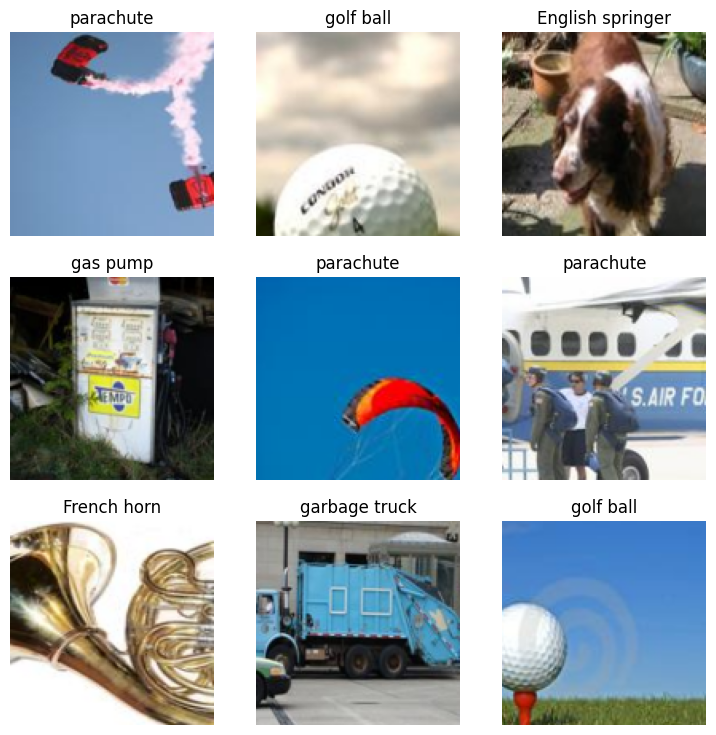

In [ ]:
_dls(64).show_batch()

In [ ]:
models = ['xresnet34', 'xse_resnext50', 'xresnet18']

In [ ]:
#batch_sizes = (32, 64, 128, 256, 512, 1024, 2048)
batch_sizes = (2, 4, 8, 16)
lrs = (1e-4, 1e-3, 1e-2)

In [ ]:
wandb.login()

In [ ]:
for bs in batch_sizes:
    dls = _dls(bs)
    assert dls.bs == bs
    for model in models:
        if model == 'xse_resnext50' and bs < 2: continue # avoid Expected more than 1 value per channel when training, got input size torch.Size([1, 4096])
        for lr in lrs:
            wandb.init(
                project="tinyscale-lab",
                name=f"imagenette-{model}-bs-{bs}-lr-{lr}",
                tags=[f"bs={bs}", f"model={model}", f"lr={lr}"]
                )
            if model == 'xse_resnext50': learn = vision_learner(dls, xse_resnext50, metrics=accuracy, pretrained=False, cbs=WandbCallback())
            if model == 'xresnet18': learn = Learner(dls, xresnet18(), metrics=accuracy, cbs=WandbCallback())
            if model == 'xresnet34': learn = Learner(dls, xresnet34(n_out=10), metrics=accuracy, cbs=WandbCallback())

            with learn.no_logging() and learn.no_mbar(): learn.fit_one_cycle(5, lr)
            wandb.finish()

Using `lr_find`, I found that xresnet18 was stable for 1e-4, 1e-3 and 1e-2 LRs but the other two were not. Instead, they were stable for LRs of 1e-7, 1e-6 and 1e-5. So I ran training runs for those two models and LRs for batch sizes of 2, 4, 8 and 16.

In [ ]:
for bs in batch_sizes:
    dls = _dls(bs)
    assert dls.bs == bs
    for model in ['xresnet34', 'xse_resnext50']:
        if model == 'xse_resnext50' and bs < 2: continue # avoid Expected more than 1 value per channel when training, got input size torch.Size([1, 4096])
        for lr in [1e-7, 1e-6, 1e-5]:
            wandb.init(
                project="tinyscale-lab",
                name=f"imagenette-{model}-bs-{bs}-lr-{lr}",
                tags=[f"bs={bs}", f"model={model}", f"lr={lr}"]
                )
            if model == 'xse_resnext50': learn = vision_learner(dls, xse_resnext50, metrics=accuracy, pretrained=False, cbs=WandbCallback())
            if model == 'xresnet18': learn = Learner(dls, xresnet18(), metrics=accuracy, cbs=WandbCallback())
            if model == 'xresnet34': learn = Learner(dls, xresnet34(n_out=10), metrics=accuracy, cbs=WandbCallback())

            with learn.no_logging() and learn.no_mbar(): learn.fit_one_cycle(5, lr)
            wandb.finish()